In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Iterations v/s Loss Storage
iters = [0]
loss_store = []

# Boundary Conditions 
left_temp = 1
right_temp = 0
x_l = 0
x_r = 0.7
t_i = 0
t_f = 1
s_i = 0.000000001
T_i = 0

# Parameters of the equation
k1 = 0.05
k2 = 0.8

# Setup training and test dataset
N_x = 50
N_t = 50
x_train = np.linspace(x_l, x_r, N_x)
x_train = np.tile(x_train, N_t)
t_train = np.linspace(t_i, t_f, N_t)
t_train = np.repeat(t_train, N_x)

x_train = torch.FloatTensor(x_train)
t_train = torch.FloatTensor(t_train)   

null = torch.zeros(N_x*N_t)

x_train = x_train.unsqueeze(-1)
t_train = t_train.unsqueeze(-1)
x_train = x_train.clone().detach().requires_grad_(True)
t_train = t_train.clone().detach().requires_grad_(True)
null = null.unsqueeze(-1)

# Setup NN
n_input = 2
n_output = 1
n_nodes = 5
NN1 = nn.Sequential( nn.Linear(n_input, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

n_input = 1
NN2 = nn.Sequential( nn.Linear(1, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

for layer in NN1.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.2)
            
for layer in NN2.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.2)

# Hyper-parameters
learning_rate = 1e-4
n_iters = 52000
            
#loss function weights

w1 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1
w6 = 1

# Setup Loss function and Optimiser
mse = nn.MSELoss()
optimiser = torch.optim.Adam([*NN1.parameters(), *NN2.parameters()], lr=learning_rate)


start = time.time()
N_ic1 = torch.sum( torch.mul( torch.where(t_train == t_i,1,0), torch.where(x_train > x_l,1,0) )).detach().numpy().item()
initial_points1 = torch.mul( torch.where(t_train == t_i,1,0), torch.where(x_train > x_l,1,0) )
initial_points2 = torch.where(t_train == t_i,1,0)
boundary_points = torch.where(x_train == x_l,1,0)
# For training NN
for i in range(n_iters):
    
    T = NN1( torch.cat((x_train, t_train),1) )
    dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0] 
    s = NN2(t_train)
    Ts = NN1( torch.cat((s, t_train),1) )
    dTsdx = torch.autograd.grad(Ts, s, grad_outputs=torch.ones_like(Ts), create_graph=True)[0]
    dsdt = torch.autograd.grad(s, t_train, grad_outputs=torch.ones_like(s), create_graph=True)[0]
    
    optimiser.zero_grad()
    
    N_eq1 = torch.sum(torch.where(s > x_train,1,0)).detach().numpy().item()
    eq1 = w1*torch.sum( torch.square( torch.mul( s > x_train, (dTdt-k1*dT2dx2) ) ) )/N_eq1 
    
    if(N_eq1 == 0):
        eq1 = torch.FloatTensor(0)
        
    ic1 = w2*torch.sum( torch.square( torch.mul( initial_points1 ,(T - T_i) ) ) )/N_x 
    bc1 = w3*torch.sum( torch.square( torch.mul( boundary_points,(T - torch.sqrt(0.3 + t_train*0.7)) ) ) )/N_t
    bc2 = w4*mse( Ts - right_temp, null ) 
    eq2 = w5*mse( dsdt+k2*dTsdx, null ) 
    ic2 = w6*torch.sum( torch.square( torch.mul( initial_points2, (s - s_i) ) ) )/N_x 
    loss = eq1 + bc1 + bc2 + ic1 + eq2 + ic2
    
    loss.backward()   
    optimiser.step()
    
    iters.append(iters[-1]+1)
    loss_store.append(loss.detach().numpy())
    
    if i%2000 == 0:
        print('epoch = ',i,', loss = ',loss.detach().numpy())
        print('eq1_loss = ',eq1.detach().numpy())
        print('ic1_loss = ',ic1.detach().numpy())
        print('bc1_loss = ',bc1.detach().numpy())
        print('bc2_loss = ',bc2.detach().numpy())
        print('eq2_loss = ',eq2.detach().numpy())
        print('ic2_loss = ',ic2.detach().numpy())
        
end = time.time()
print("time elapsed = ",end-start)
# Extract Weights and Biases
w1 = list(NN1.parameters())
w2 = list(NN2.parameters())

epoch =  0 , loss =  0.7967853
eq1_loss =  2.3842407e-05
ic1_loss =  0.0048865466
bc1_loss =  0.75724685
bc2_loss =  0.0047200103
eq2_loss =  0.00012835427
ic2_loss =  0.029779691
epoch =  2000 , loss =  0.38728458
eq1_loss =  0.0033184974
ic1_loss =  0.044883627
bc1_loss =  0.25347087
bc2_loss =  0.08373122
eq2_loss =  0.00013676553
ic2_loss =  0.0017436148
epoch =  4000 , loss =  0.18747349
eq1_loss =  0.018990362
ic1_loss =  0.057075802
bc1_loss =  0.06525779
bc2_loss =  0.0382783
eq2_loss =  7.3857205e-05
ic2_loss =  0.0077973907
epoch =  6000 , loss =  0.06826761
eq1_loss =  0.008479613
ic1_loss =  0.025165645
bc1_loss =  0.0130022755
bc2_loss =  0.007863004
eq2_loss =  0.00593864
ic2_loss =  0.007818439
epoch =  8000 , loss =  0.03391607
eq1_loss =  0.0021130894
ic1_loss =  0.016029228
bc1_loss =  0.007189464
bc2_loss =  0.005005319
eq2_loss =  0.0010034376
ic2_loss =  0.002575537
epoch =  10000 , loss =  0.021108383
eq1_loss =  0.00069949764
ic1_loss =  0.010151898
bc1_loss =  0

Text(0.5, 0, 'Iterations')

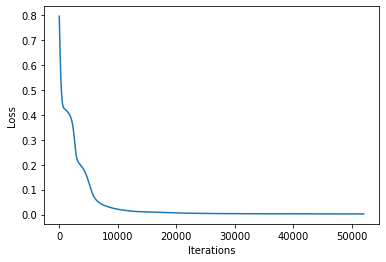

In [3]:
# Plot Loss v/s iteration
plt.figure(0)
plt.plot(iters[1:len(iters)], loss_store[0:len(iters)])
plt.ylabel('Loss')
plt.xlabel('Iterations')


In [4]:
# lam Calculation
x = []
er = []
cnt = 0
for i in np.arange(0.1, 5, 0.001):
    x.append(i)
    er.append(math.erf(x[-1]))
    cnt = cnt+1
    
x = np.array(x)
er = np.array(er)
y =[]
y = np.exp(-x*x)/(er*math.sqrt(math.pi))-x*k1/k2

for i in range(1,cnt):
    if(y[i]*y[i-1]<0):
        lam = x[i]
        print(lam)

1.3880000000000012


Text(0.5, 0, 'Domain')

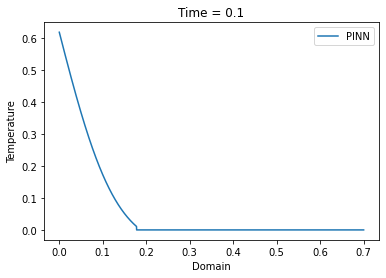

In [7]:
# Temperature Distribution

N_test = 2000

t_pred = 0.1
x_test = torch.linspace(x_r,x_l,N_test)
t_test = torch.ones(N_test)*t_pred
x_test = x_test.unsqueeze(-1)
t_test = t_test.unsqueeze(-1)

y_pred = NN1( torch.cat((x_test, t_test),1) )
s_pred = NN2(t_test)

y_pred = y_pred.detach().numpy()
s_pred = s_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()

# PINN
for i in range(N_test):
    if(x_test[i]>s_pred[i]):
        y_pred[i] = 0 
plt.plot(x_test, y_pred)
        
# Analytical
s_an = np.sqrt(k1*t_pred)*2*lam
y_an = []
for i in range(N_test):
    if(x_test[i]>s_an):
        y_an.append(0)
    else:
        y_an.append(1 - math.erf( x_test[i]/( 2*np.sqrt(k1*t_test[i]) ) )/ math.erf(lam) )     
# plt.plot(x_test, y_an)

plt.legend(['PINN', 'Analytical'])
plt.title('Time = '+ str(t_pred) )
plt.ylabel('Temperature')
plt.xlabel('Domain')

Text(0, 0.5, 'Interface Position')

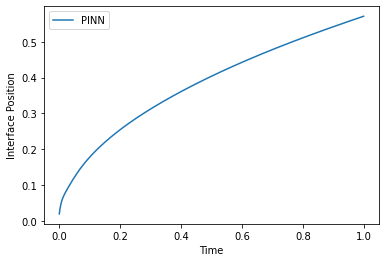

In [6]:
# Interface Position

t_test = torch.linspace(t_i, 1, N_test)
t_test = t_test.unsqueeze(-1)
s_pred = NN2(t_test)
T_interface = NN1( torch.cat((s_pred, t_test),1) )

t_test = t_test.detach().numpy()
s_pred = s_pred.detach().numpy()
T_interface = T_interface.detach().numpy()

plt.plot(t_test,s_pred)
# plt.plot(t_test, np.sqrt(k1*t_test)*2*lam)
plt.legend(['PINN', 'Analytical'])
plt.xlabel('Time')
plt.ylabel('Interface Position')